In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
import numpy as np
import dataset_utils
import importlib
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier 
from sklearn.preprocessing import StandardScaler

importlib.reload(dataset_utils)

<module 'dataset_utils' from '/home/fogliodicarta/Desktop/InsectClassification/dataset_utils.py'>

# Dati del PAPER

In [2]:
from scipy.io import loadmat
paper_data = loadmat('data/INSECTS/data.mat')
paper_splits = loadmat('data/INSECTS/splits.mat')

train_indices = paper_splits['train_loc']-1
image_train_features = torch.tensor(paper_data['embeddings_img'][train_indices]).squeeze()
expanded_train_dna_features = torch.tensor(paper_data['embeddings_dna'][train_indices]).squeeze()
image_train_labels= torch.tensor(paper_data['labels'][train_indices],dtype=int).squeeze()-1
expanded_train_dna_labels= torch.tensor(paper_data['labels'][train_indices],dtype=int).squeeze()-1

val_indices = np.concatenate((paper_splits['val_seen_loc'],paper_splits['val_unseen_loc']),axis=1)-1
image_val_features = torch.tensor(paper_data['embeddings_img'][val_indices]).squeeze()
expanded_val_dna_features = torch.tensor(paper_data['embeddings_dna'][val_indices]).squeeze()
image_val_labels= torch.tensor(paper_data['labels'][val_indices],dtype=int).squeeze()-1
expanded_val_dna_labels= torch.tensor(paper_data['labels'][val_indices],dtype=int).squeeze()-1


test_indices = np.concatenate((paper_splits['test_seen_loc'],paper_splits['test_unseen_loc']),axis=1)-1
image_test_features = torch.tensor(paper_data['embeddings_img'][test_indices]).squeeze()
expanded_test_dna_features = torch.tensor(paper_data['embeddings_dna'][test_indices]).squeeze()
image_test_labels= torch.tensor(paper_data['labels'][test_indices],dtype=int).squeeze()-1
expanded_test_dna_labels= torch.tensor(paper_data['labels'][test_indices],dtype=int).squeeze()-1
species2genus = paper_data['G'].astype(int) #np.vstack([-1,paper_data['G'].astype(int)])
species2genus = species2genus - min(species2genus)
described_species_labels = image_train_labels.unique().numpy()

n_classes = 1040

In [3]:
species2genus
#TWO HEADS
class InsectNet(torch.nn.Module):
    def __init__(self):
        super(InsectNet, self).__init__()
        self.linear1 = nn.Linear(2548,1000)
        self.act1 = nn.LeakyReLU()
        self.linearHeadGenus = nn.Linear(1000,368)
        self.linearHeadSpecies = nn.Linear(1000,n_classes)
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x_species = self.linearHeadSpecies(x)
        x_genus = self.linearHeadGenus(x)
        x_species = torch.nn.functional.softmax(x_species)
        x_genus = torch.nn.functional.softmax(x_genus)
        return x_species,x_genus

'''ONE HEAD ONLy class InsectNet(torch.nn.Module):
    def __init__(self):
        super(InsectNet, self).__init__()
        self.linear1 = nn.Linear(2548,368)
        self.act1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(368,n_classes)
        self.act2 = nn.Softmax()
    def forward(self, x):
        x = self.linear1(x)
         = torch.nn.functional.softmax(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        return x,x_genus'''

'ONE HEAD ONLy class InsectNet(torch.nn.Module):\n    def __init__(self):\n        super(InsectNet, self).__init__()\n        self.linear1 = nn.Linear(2548,368)\n        self.act1 = nn.LeakyReLU()\n        self.linear2 = nn.Linear(368,n_classes)\n        self.act2 = nn.Softmax()\n    def forward(self, x):\n        x = self.linear1(x)\n         = torch.nn.functional.softmax(x)\n        x = self.act1(x)\n        x = self.linear2(x)\n        x = self.act2(x)\n        return x,x_genus'

In [4]:
species2genus.shape

(1040, 1)

In [5]:
image_train_features.shape

torch.Size([12481, 2048])

In [6]:
image_train_labels.shape

torch.Size([12481])

In [7]:
expanded_train_dna_labels.shape

torch.Size([12481])

In [8]:
expanded_train_dna_features.shape

torch.Size([12481, 500])

# CONTROLLARE STA ROBA DI TRAIN VAL PRIMA DELLO SCALER

In [9]:
is_train_val = False 
print("ATTENZIONE A STA ROBA NON DIMENTICARE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
complete_train_features = torch.cat((expanded_train_dna_features,image_train_features),dim=1)
complete_val_features = torch.cat((expanded_val_dna_features,image_val_features),dim=1)
complete_test_features = torch.cat((expanded_test_dna_features,image_test_features),dim=1)
if is_train_val:
    complete_train_features = torch.cat((complete_train_features,complete_val_features),dim=0)
    complete_val_features = complete_test_features
    image_train_labels = torch.cat((image_train_labels,image_val_labels),dim=0)
    image_val_labels = image_test_labels

scaler = StandardScaler()

complete_train_features_scaled = scaler.fit_transform(complete_train_features)
complete_val_features_scaled = scaler.transform(complete_val_features)

ATTENZIONE A STA ROBA NON DIMENTICARE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [10]:
expanded_train_dna_features.shape
image_train_features.shape
complete_train_features_scaled.shape

(12481, 2548)

In [11]:
complete_val_features_scaled.shape

(6939, 2548)

In [12]:
from torch.utils.data import Dataset
class FeatureDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        #if self.transform:
        #    x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
        #    x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)
complete_train_features_scaled = torch.tensor(complete_train_features_scaled,dtype=torch.float)
complete_val_features_scaled = torch.tensor(complete_val_features_scaled,dtype=torch.float)

d_train = FeatureDataset(complete_train_features_scaled,image_train_labels)
d_val = FeatureDataset(complete_val_features_scaled,image_val_labels)

In [13]:
species2genus.min()
species2genus.max()

367

In [14]:
species2genus.shape

(1040, 1)

In [15]:
d_train[0][0].shape

torch.Size([2548])

In [16]:
d_train[0]

(tensor([-0.9312, -1.3331, -1.0852,  ...,  0.9381, -1.4899, -1.2142]),
 tensor(0))

## Classification

# Fitting model

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = InsectNet().to(device)
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

In [18]:
from torch.utils.data import DataLoader
batch_size = 1000
train_loader = DataLoader(d_train,shuffle=True,batch_size = batch_size)
val_loader = DataLoader(d_val,shuffle=True,batch_size = batch_size)
dataloaders = {'train':train_loader,'val':val_loader}
dataset_sizes = {'train':len(d_train.targets),'val':len(d_val.targets)}

In [19]:
from tqdm.notebook import tqdm
def fit(epochs,dataloaders,optimizer,model,start_idx=0):
    criterion = torch.nn.NLLLoss()
    if device == 'cuda:0':
        torch.cuda.empty_cache()
    
    train_losses = []
    train_scores = []
    val_losses = []
    val_scores = []
    for epoch in range(epochs):
        running_train_corrects = 0
        for features,labels in tqdm(dataloaders['train']):
            
            model.train()
            genus_labels = torch.tensor(species2genus[labels.int()]).squeeze().to(device)
            features = features.to(device)
            labels = labels.type(torch.LongTensor).to(device)
            
            optimizer.zero_grad()

            #print(genus_labels.shape)
            #print(labels.shape)
            #break
            predicted_labels,predicted_genus_labels = model(features)
            train_loss = criterion(predicted_labels,labels)
            train_genus_loss = criterion(predicted_genus_labels,genus_labels)
            #print(train_genus_loss.shape)
            #print(train_loss.shape)
            train_loss+=train_genus_loss
            
            train_loss.backward()
            optimizer.step()
            
            _, preds = torch.max(predicted_labels, 1)
            running_train_corrects += torch.sum(preds == labels.data)
        train_losses.append(train_loss)
        
        running_val_corrects = 0
        for features,labels in tqdm(dataloaders['val']):
            
            model.eval()
            with torch.no_grad():
                features = features.to(device)
                labels = labels.type(torch.LongTensor).to(device)
                optimizer.zero_grad()
                
                predicted_labels,predicted_genus_labels = model(features)
                val_loss = criterion(predicted_labels,labels)
                
                _, preds = torch.max(predicted_labels, 1)
                running_val_corrects += torch.sum(preds == labels.data)
        val_losses.append(val_loss)
        epoch_train_acc = running_train_corrects.double() / dataset_sizes['train']
        epoch_val_acc = running_val_corrects.double() / dataset_sizes['val']
        print("Epoch [{}/{}], train_loss: {:.4f},  train_score: {:.4f},val_loss: {:.4f},  val_score: {:.4f}".format(
            epoch+1, epochs, train_loss, epoch_train_acc,val_loss,epoch_val_acc))
    return train_losses

In [52]:

_ = fit(100,dataloaders,optimizer,model)

  0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_27861/438739160.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_species = torch.nn.functional.softmax(x_species)
/tmp/ipykernel_27861/438739160.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_genus = torch.nn.functional.softmax(x_genus)


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1/100], train_loss: -1.9665,  train_score: 0.9632,val_loss: -0.4114,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2/100], train_loss: -1.9561,  train_score: 0.9632,val_loss: -0.3680,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3/100], train_loss: -1.9623,  train_score: 0.9632,val_loss: -0.4076,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4/100], train_loss: -1.9540,  train_score: 0.9632,val_loss: -0.3905,  val_score: 0.3962


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5/100], train_loss: -1.9727,  train_score: 0.9632,val_loss: -0.3874,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6/100], train_loss: -1.9686,  train_score: 0.9632,val_loss: -0.3592,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7/100], train_loss: -1.9685,  train_score: 0.9632,val_loss: -0.3830,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8/100], train_loss: -1.9706,  train_score: 0.9632,val_loss: -0.3917,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9/100], train_loss: -1.9561,  train_score: 0.9632,val_loss: -0.3700,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [10/100], train_loss: -1.9623,  train_score: 0.9632,val_loss: -0.3989,  val_score: 0.3966


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [11/100], train_loss: -1.9623,  train_score: 0.9632,val_loss: -0.3780,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [12/100], train_loss: -1.9665,  train_score: 0.9632,val_loss: -0.3856,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [13/100], train_loss: -1.9790,  train_score: 0.9632,val_loss: -0.3762,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [14/100], train_loss: -1.9602,  train_score: 0.9632,val_loss: -0.4095,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [15/100], train_loss: -1.9602,  train_score: 0.9632,val_loss: -0.4074,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [16/100], train_loss: -1.9582,  train_score: 0.9632,val_loss: -0.3980,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [17/100], train_loss: -1.9623,  train_score: 0.9632,val_loss: -0.4055,  val_score: 0.3962


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [18/100], train_loss: -1.9789,  train_score: 0.9632,val_loss: -0.3926,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [19/100], train_loss: -1.9602,  train_score: 0.9632,val_loss: -0.4035,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [20/100], train_loss: -1.9415,  train_score: 0.9632,val_loss: -0.4098,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [21/100], train_loss: -1.9685,  train_score: 0.9632,val_loss: -0.3965,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [22/100], train_loss: -1.9685,  train_score: 0.9632,val_loss: -0.3635,  val_score: 0.3966


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [23/100], train_loss: -1.9644,  train_score: 0.9632,val_loss: -0.3728,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [24/100], train_loss: -1.9540,  train_score: 0.9632,val_loss: -0.3923,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [25/100], train_loss: -1.9665,  train_score: 0.9632,val_loss: -0.3860,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [26/100], train_loss: -1.9706,  train_score: 0.9632,val_loss: -0.4038,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [27/100], train_loss: -1.9748,  train_score: 0.9632,val_loss: -0.3810,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [28/100], train_loss: -1.9519,  train_score: 0.9632,val_loss: -0.4039,  val_score: 0.3966


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [29/100], train_loss: -1.9602,  train_score: 0.9632,val_loss: -0.4023,  val_score: 0.3962


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [30/100], train_loss: -1.9685,  train_score: 0.9632,val_loss: -0.3910,  val_score: 0.3966


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [31/100], train_loss: -1.9665,  train_score: 0.9632,val_loss: -0.4162,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [32/100], train_loss: -1.9603,  train_score: 0.9632,val_loss: -0.3869,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [33/100], train_loss: -1.9706,  train_score: 0.9632,val_loss: -0.4054,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [34/100], train_loss: -1.9457,  train_score: 0.9632,val_loss: -0.3748,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [35/100], train_loss: -1.9582,  train_score: 0.9632,val_loss: -0.3961,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [36/100], train_loss: -1.9748,  train_score: 0.9632,val_loss: -0.3924,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [37/100], train_loss: -1.9727,  train_score: 0.9632,val_loss: -0.4000,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [38/100], train_loss: -1.9581,  train_score: 0.9632,val_loss: -0.3602,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [39/100], train_loss: -1.9623,  train_score: 0.9632,val_loss: -0.4140,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [40/100], train_loss: -1.9665,  train_score: 0.9632,val_loss: -0.4077,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [41/100], train_loss: -1.9727,  train_score: 0.9632,val_loss: -0.4033,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [42/100], train_loss: -1.9748,  train_score: 0.9632,val_loss: -0.3941,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [43/100], train_loss: -1.9727,  train_score: 0.9632,val_loss: -0.3966,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [44/100], train_loss: -1.9665,  train_score: 0.9632,val_loss: -0.4048,  val_score: 0.3966


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [45/100], train_loss: -1.9581,  train_score: 0.9632,val_loss: -0.4036,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [46/100], train_loss: -1.9748,  train_score: 0.9632,val_loss: -0.4098,  val_score: 0.3962


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [47/100], train_loss: -1.9623,  train_score: 0.9632,val_loss: -0.4079,  val_score: 0.3966


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [48/100], train_loss: -1.9415,  train_score: 0.9632,val_loss: -0.3888,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [49/100], train_loss: -1.9831,  train_score: 0.9632,val_loss: -0.4099,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [50/100], train_loss: -1.9395,  train_score: 0.9632,val_loss: -0.3816,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [51/100], train_loss: -1.9665,  train_score: 0.9632,val_loss: -0.4258,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [52/100], train_loss: -1.9623,  train_score: 0.9632,val_loss: -0.3824,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [53/100], train_loss: -1.9540,  train_score: 0.9632,val_loss: -0.4022,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [54/100], train_loss: -1.9561,  train_score: 0.9632,val_loss: -0.3906,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [55/100], train_loss: -1.9581,  train_score: 0.9632,val_loss: -0.3831,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [56/100], train_loss: -1.9665,  train_score: 0.9632,val_loss: -0.3983,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [57/100], train_loss: -1.9581,  train_score: 0.9632,val_loss: -0.3944,  val_score: 0.3966


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [58/100], train_loss: -1.9602,  train_score: 0.9632,val_loss: -0.3938,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [59/100], train_loss: -1.9665,  train_score: 0.9632,val_loss: -0.3850,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [60/100], train_loss: -1.9644,  train_score: 0.9632,val_loss: -0.3999,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [61/100], train_loss: -1.9873,  train_score: 0.9632,val_loss: -0.3978,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [62/100], train_loss: -1.9602,  train_score: 0.9632,val_loss: -0.3907,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [63/100], train_loss: -1.9519,  train_score: 0.9632,val_loss: -0.4022,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [64/100], train_loss: -1.9540,  train_score: 0.9632,val_loss: -0.3675,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [65/100], train_loss: -1.9665,  train_score: 0.9632,val_loss: -0.3960,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [66/100], train_loss: -1.9727,  train_score: 0.9632,val_loss: -0.3842,  val_score: 0.3962


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [67/100], train_loss: -1.9498,  train_score: 0.9632,val_loss: -0.4117,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [68/100], train_loss: -1.9602,  train_score: 0.9632,val_loss: -0.3987,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [69/100], train_loss: -1.9519,  train_score: 0.9632,val_loss: -0.3907,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [70/100], train_loss: -1.9644,  train_score: 0.9632,val_loss: -0.3542,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [71/100], train_loss: -1.9664,  train_score: 0.9632,val_loss: -0.3845,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [72/100], train_loss: -1.9602,  train_score: 0.9632,val_loss: -0.3859,  val_score: 0.3962


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [73/100], train_loss: -1.9602,  train_score: 0.9632,val_loss: -0.3822,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [74/100], train_loss: -1.9644,  train_score: 0.9632,val_loss: -0.4203,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [75/100], train_loss: -1.9769,  train_score: 0.9632,val_loss: -0.4011,  val_score: 0.3966


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [76/100], train_loss: -1.9519,  train_score: 0.9632,val_loss: -0.3955,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [77/100], train_loss: -1.9561,  train_score: 0.9632,val_loss: -0.3962,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [78/100], train_loss: -1.9540,  train_score: 0.9632,val_loss: -0.3777,  val_score: 0.3962


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [79/100], train_loss: -1.9685,  train_score: 0.9632,val_loss: -0.4017,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [80/100], train_loss: -1.9602,  train_score: 0.9632,val_loss: -0.3813,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [81/100], train_loss: -1.9706,  train_score: 0.9632,val_loss: -0.4072,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [82/100], train_loss: -1.9374,  train_score: 0.9632,val_loss: -0.4217,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [83/100], train_loss: -1.9602,  train_score: 0.9632,val_loss: -0.4055,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [84/100], train_loss: -1.9748,  train_score: 0.9632,val_loss: -0.3956,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [85/100], train_loss: -1.9810,  train_score: 0.9632,val_loss: -0.3851,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [86/100], train_loss: -1.9603,  train_score: 0.9632,val_loss: -0.3848,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [87/100], train_loss: -1.9540,  train_score: 0.9632,val_loss: -0.3674,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [88/100], train_loss: -1.9540,  train_score: 0.9632,val_loss: -0.3975,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [89/100], train_loss: -1.9561,  train_score: 0.9632,val_loss: -0.3999,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [90/100], train_loss: -1.9623,  train_score: 0.9632,val_loss: -0.4046,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [91/100], train_loss: -1.9519,  train_score: 0.9632,val_loss: -0.3704,  val_score: 0.3962


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [92/100], train_loss: -1.9519,  train_score: 0.9632,val_loss: -0.3799,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [93/100], train_loss: -1.9623,  train_score: 0.9632,val_loss: -0.3806,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [94/100], train_loss: -1.9582,  train_score: 0.9632,val_loss: -0.3887,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [95/100], train_loss: -1.9665,  train_score: 0.9632,val_loss: -0.3567,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [96/100], train_loss: -1.9665,  train_score: 0.9632,val_loss: -0.3694,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [97/100], train_loss: -1.9769,  train_score: 0.9632,val_loss: -0.4123,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [98/100], train_loss: -1.9644,  train_score: 0.9632,val_loss: -0.4183,  val_score: 0.3965


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [99/100], train_loss: -1.9581,  train_score: 0.9632,val_loss: -0.3746,  val_score: 0.3963


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [100/100], train_loss: -1.9686,  train_score: 0.9632,val_loss: -0.4184,  val_score: 0.3965


In [53]:
with torch.no_grad():
    model.eval()
    val_predicted_probs,val_predicted_probs_genus = model(d_val.data.cuda())

/tmp/ipykernel_27861/438739160.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_species = torch.nn.functional.softmax(x_species)
/tmp/ipykernel_27861/438739160.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_genus = torch.nn.functional.softmax(x_genus)


In [54]:
val_predicted_probs[0]

tensor([9.9246e-01, 2.6089e-04, 1.8138e-09,  ..., 1.1878e-06, 7.5275e-06,
        8.8169e-09], device='cuda:0')

In [55]:
val_predicted_probs = val_predicted_probs.cpu()
val_predicted_probs_genus = val_predicted_probs_genus.cpu()

In [56]:
val_predicted_probs[4].max()

tensor(0.8689)

In [57]:
val_predicted_probs[4].topk(3)

torch.return_types.topk(
values=tensor([0.8689, 0.0237, 0.0133]),
indices=tensor([  2, 712, 152]))

In [58]:
image_val_labels[4]

tensor(2)

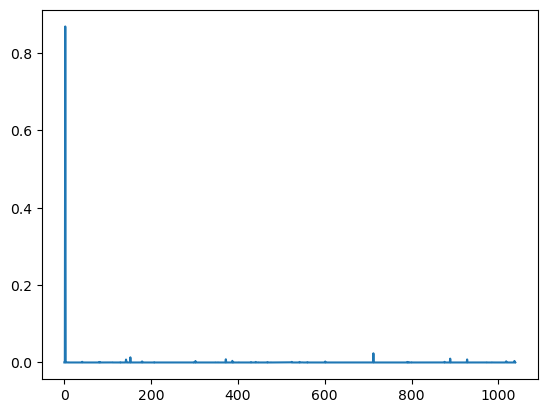

In [59]:
plt.plot(val_predicted_probs[4].cpu())

In [60]:

val_predicted_labels = val_predicted_probs.argmax(axis=1)
val_predicted_labels_genus = val_predicted_probs_genus.argmax(axis=1)

In [61]:
print(val_predicted_labels[4])
print(image_val_labels[4])

tensor(2)
tensor(2)


In [62]:
    #val_predicted_probs -= val_predicted_probs.min(dim=1).values.unsqueeze(1)
    
    #val_predicted_probs = val_predicted_probs/(val_predicted_probs.sum(dim=1).unsqueeze(1))
    #val_predicted_probs = val_predicted_probs.cpu().numpy()

In [63]:
print(val_predicted_probs[10].min())
print(val_predicted_probs[10].sum())

tensor(9.9266e-12)
tensor(1.)


In [64]:
val_predicted_labels

tensor([   0,    0,    1,  ..., 1032, 1032, 1033])

# Secondo top2 method

In [65]:
tprs = []
fprs = []
correct_genus_rate = []
correct_species_rate = []
thresholds = []
possible_thresholds = [x / 1000 for x in range(800, 1000, 1)]
for t in possible_thresholds:#ATTENZIONE QUA E' DIVERSO
    entropy_threshold = t
    thresholds.append(entropy_threshold)
    #print(val_predicted_probs.shape)
    n_undescribed_samples = 0
    n_described_samples = 0
    n_correct_undescribed_samples = 0
    n_correct_described_samples = 0
    n_correct_genus = 0 
    n_correct_species = 0 
    for i in range(len(image_val_labels)):
        label_best_specie = val_predicted_labels[i]
       
        #assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
        genus_of_best_species = species2genus[label_best_specie.item()]

        top2 = torch.tensor(val_predicted_probs[i]).topk(2)#ATTENZIONE QUA E' DIVERSO
        #print(top2)
        if (top2.values[0]-top2.values[1]) > entropy_threshold*top2.values[0]:#species 
            if image_val_labels[i].item() in described_species_labels:#i needed to guess species
                n_described_samples +=1
                if label_best_specie == image_val_labels[i]:#guessed species is correct
                    #n_correct_described_samples+=1
                    n_correct_species+=1
            else:# i needed to guess genus
                n_undescribed_samples+=1
        else:#genus
            if image_val_labels[i].item() in described_species_labels:#i needed to guess species
                n_described_samples +=1
            else:# i needed to guess genus
                n_undescribed_samples+=1
                #if genus_of_best_species == species2genus[image_val_labels[i]]:#guessed genus is correct
                #ATTENZIONE QUA E' DIVERSO
                if val_predicted_labels_genus[i].item() == species2genus[image_val_labels[i]].item():#guessed genus is correct
                    #n_correct_described_samples+=1
                    n_correct_genus+=1
            
    tprs.append(n_correct_undescribed_samples/n_undescribed_samples) # TPR = recall = sensitivity
    fprs.append(1-n_correct_described_samples/n_described_samples) # 1-TNR = 1 - specificity
    correct_genus_rate.append(n_correct_genus/n_undescribed_samples)
    correct_species_rate.append(n_correct_species/n_described_samples)

/tmp/ipykernel_27861/2687641837.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top2 = torch.tensor(val_predicted_probs[i]).topk(2)#ATTENZIONE QUA E' DIVERSO


In [66]:
for index in range(0,len(thresholds),2):
    #print(index)
    print(correct_genus_rate[index])
    print(correct_species_rate[index])
    print('\n\n')

0.47146640982422344
0.9831299353912419



0.4733927281483265
0.9831299353912419



0.47555983626294246
0.9831299353912419



0.4772453647965326
0.9827709978463748



0.47820852395858415
0.9827709978463748



0.48085721165422585
0.9827709978463748



0.48230195039730317
0.9827709978463748



0.48446905851191907
0.9827709978463748



0.4871177462075608
0.9827709978463748



0.4883216951601252
0.9827709978463748



0.49048880327474115
0.9827709978463748



0.4916927522273056
0.9827709978463748



0.49337828076089574
0.9827709978463748



0.49723091740910186
0.9827709978463748



0.49963881531423066
0.9827709978463748



0.501083554057308
0.9827709978463748



0.5025282928003852
0.9824120603015075



0.5034914519624368
0.9824120603015075



0.5063809294485914
0.9820531227566404



0.5090296171442331
0.9816941852117731



0.5099927763062846
0.9816941852117731



0.5121598844209005
0.9816941852117731



0.5160125210691067
0.9816941852117731



0.5184204189742355
0.9816941852117731



0.51986

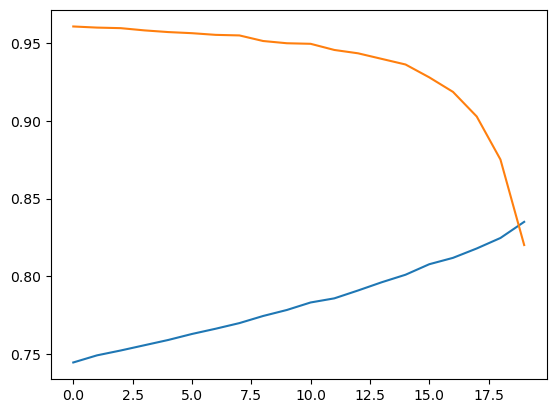

In [70]:
plt.plot(correct_genus_rate[-20:])
plt.plot(correct_species_rate[-20:])

In [53]:
thresholds

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009,
 0.01,
 0.011,
 0.012,
 0.013,
 0.014,
 0.015,
 0.016,
 0.017,
 0.018,
 0.019,
 0.02,
 0.021,
 0.022,
 0.023,
 0.024,
 0.025,
 0.026,
 0.027,
 0.028,
 0.029,
 0.03,
 0.031,
 0.032,
 0.033,
 0.034,
 0.035,
 0.036,
 0.037,
 0.038,
 0.039,
 0.04,
 0.041,
 0.042,
 0.043,
 0.044,
 0.045,
 0.046,
 0.047,
 0.048,
 0.049,
 0.05,
 0.051,
 0.052,
 0.053,
 0.054,
 0.055,
 0.056,
 0.057,
 0.058,
 0.059,
 0.06,
 0.061,
 0.062,
 0.063,
 0.064,
 0.065,
 0.066,
 0.067,
 0.068,
 0.069,
 0.07,
 0.071,
 0.072,
 0.073,
 0.074,
 0.075,
 0.076,
 0.077,
 0.078,
 0.079,
 0.08,
 0.081,
 0.082,
 0.083,
 0.084,
 0.085,
 0.086,
 0.087,
 0.088,
 0.089,
 0.09,
 0.091,
 0.092,
 0.093,
 0.094,
 0.095,
 0.096,
 0.097,
 0.098,
 0.099,
 0.1,
 0.101,
 0.102,
 0.103,
 0.104,
 0.105,
 0.106,
 0.107,
 0.108,
 0.109,
 0.11,
 0.111,
 0.112,
 0.113,
 0.114,
 0.115,
 0.116,
 0.117,
 0.118,
 0.119,
 0.12,
 0.121,
 0.122,
 0.123,
 0.124,
 0.125,
 0.126,

# Random Forest

In [11]:
clf = RandomForestClassifier(min_samples_leaf=2,n_jobs=-1)
clf = clf.fit(complete_train_features_scaled, image_train_labels)

train_predicted_labels = clf.predict(complete_train_features_scaled)
print('train')
val_predicted_labels= clf.predict(complete_val_features_scaled)
print('val')
temp_val_predicted_probs = clf.predict_proba(complete_val_features_scaled)
print('proba')
val_predicted_probs = np.zeros((len(temp_val_predicted_probs),n_classes))
for i, cls in enumerate(np.arange(n_classes)):
    if cls in clf.classes_:
        val_predicted_probs[:, cls] = temp_val_predicted_probs[:, list(clf.classes_).index(cls)]

train
val
proba


In [12]:
temp_val_predicted_probs

array([[0.43933333, 0.01      , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.44154762, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02      , 0.37233333, 0.        , ..., 0.        , 0.        ,
        0.01      ],
       ...,
       [0.        , 0.01333333, 0.        , ..., 0.        , 0.00333333,
        0.00666667],
       [0.        , 0.01333333, 0.        , ..., 0.        , 0.00333333,
        0.        ],
       [0.        , 0.01      , 0.        , ..., 0.        , 0.00333333,
        0.00666667]])

In [13]:
feature_importances = clf.feature_importances_
feature_importances

array([2.82000009e-03, 1.25816369e-03, 1.11023618e-03, ...,
       4.63357799e-05, 1.09040418e-04, 4.63141551e-05])

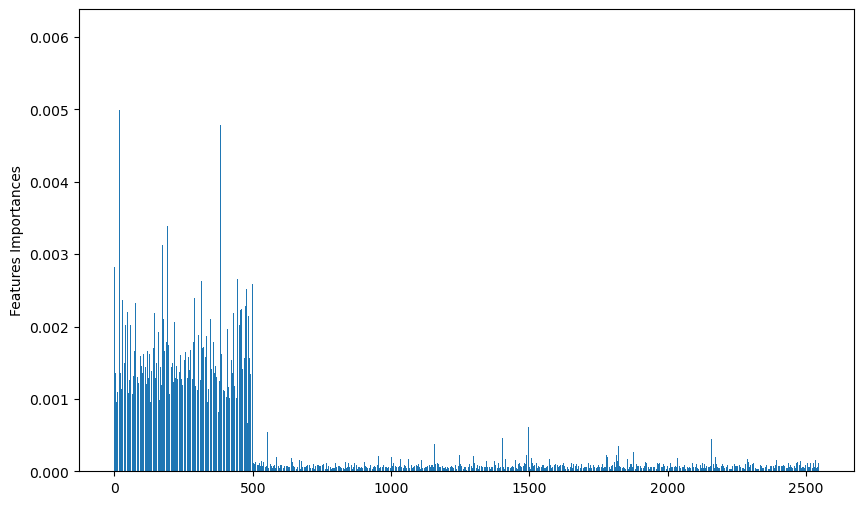

In [14]:
feature_names = [f'Feature {i+1}' for i in range(complete_train_features.shape[1])]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, align='center')
plt.ylabel('Features Importances')
plt.show()

# Accuracies

In [15]:
print(f"Training species accuracy:{np.count_nonzero(train_predicted_labels==image_train_labels.numpy())/len(image_train_labels)}")

print(f"Validation species accuracy:{np.count_nonzero(val_predicted_labels==image_val_labels.numpy())/len(image_val_labels)}")

Training species accuracy:1.0
Validation species accuracy:0.395157803718115


In [16]:
import math
n_correct_genus = 0
for i in range(len(image_val_labels)):
    #label_best_specie = val_predicted_probs[i].argmax()
    label_best_specie = val_predicted_labels[i]
    #print(val_predicted_labels[i])
    #print(val_predicted_probs[i].argmax())
    #assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
    genus_of_best_species = species2genus[label_best_specie.item()]
    #species_same_genus = [k for k,v in species2genus.items() if v == genus_of_best_species]
    #reduced_species = val_predicted_probs[i][species_same_genus]
    #normalized_reduced_species = reduced_species/(reduced_species.sum())
    
    real_genus = species2genus[image_val_labels[i].item()]
    predicted_genus = genus_of_best_species
    if real_genus == predicted_genus:
        n_correct_genus+=1
print(f"Validation genus accuracy: {n_correct_genus/len(image_val_labels)}")

Validation genus accuracy: 0.6636402939904885


In [26]:
val_predicted_labels_genus[i]

tensor(366)

0
0.0
0.9904666332162569



1
0.004448210124973522
0.9904666332162569



2
0.009425969074348655
0.9904666332162569



3
0.013238720610040246
0.9904666332162569



4
0.01779284049989409
0.9904666332162569



5
0.02160559203558568
0.9904666332162569



6
0.025630163101037915
0.9904666332162569



7
0.030502012285532724
0.9904666332162569



8
0.03526795170514722
0.9904666332162569



9
0.039504342300360096
0.9902157551430005



10
0.04363482313069265
0.9902157551430005



11
0.047553484431264566
0.9902157551430005



12
0.05242533361575937
0.9902157551430005



13
0.05708536327049354
0.9902157551430005



14
0.06163948316034738
0.9902157551430005



15
0.06619360305020122
0.9902157551430005



16
0.0699004448210125
0.9902157551430005



17
0.07487820377038763
0.9902157551430005



18
0.08027960177928405
0.9902157551430005



19
0.08652827790722305
0.9902157551430005



20
0.09087057826731625
0.9902157551430005



21
0.09563651768693074
0.9902157551430005



22
0.10040245710654522
0.99021

# Top-2 Method

In [31]:
tprs = []
fprs = []
correct_genus_rate = []
correct_species_rate = []
for t in range(0,100,1):
    entropy_threshold = t/100.0
    #print(val_predicted_probs.shape)
    n_undescribed_samples = 0
    n_described_samples = 0
    n_correct_undescribed_samples = 0
    n_correct_described_samples = 0
    n_correct_genus = 0 
    n_correct_species = 0 
    for i in range(len(image_val_labels)):
        
        label_best_specie = val_predicted_labels[i]
       
        #assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
        genus_of_best_species = species2genus[label_best_specie.item()]
        
        sorted_probs = np.sort(val_predicted_probs[i])
        sorted_probs = sorted_probs[::-1]
        
        prob_diff = abs(sorted_probs[0] - sorted_probs[1])
        #print(prob_diff)
        if image_val_labels[i].item() in described_species_labels:
            #tn
            n_described_samples +=1
            if prob_diff >= entropy_threshold:
                n_correct_described_samples+=1
                if label_best_specie == image_val_labels[i]:
                    n_correct_species+=1
        else:
            #tp
            n_undescribed_samples+=1
            if prob_diff < entropy_threshold:
                n_correct_undescribed_samples+=1
                real_genus = species2genus[image_val_labels[i].item()]
                predicted_genus = genus_of_best_species
                if real_genus == predicted_genus:
                    n_correct_genus+=1
        
            
    tprs.append(n_correct_undescribed_samples/n_undescribed_samples) # TPR = recall = sensitivity
    fprs.append(1-n_correct_described_samples/n_described_samples) # 1-TNR = 1 - specificity
    correct_genus_rate.append(n_correct_genus/n_undescribed_samples)
    correct_species_rate.append(n_correct_species/n_described_samples)

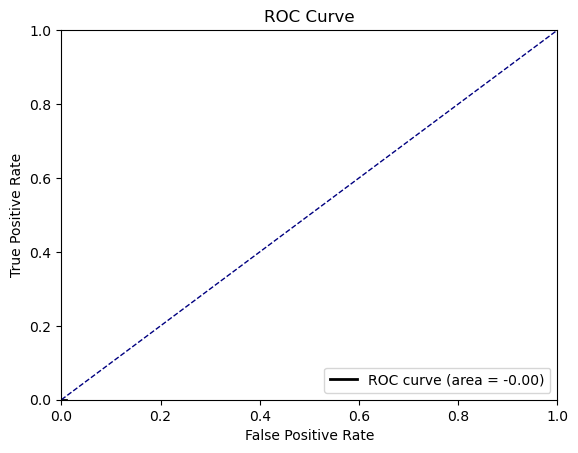

In [42]:
from sklearn.metrics import roc_curve, auc

roc_auc = auc(fprs, tprs)

plt.figure()
plt.plot(fprs, tprs, color='black', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

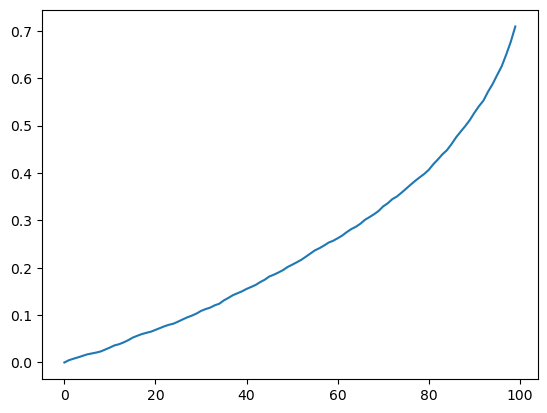

In [52]:
plt.plot(correct_genus_rate)

0.04986902625680434


Text(0, 0.5, 'Correct Genus Rate')

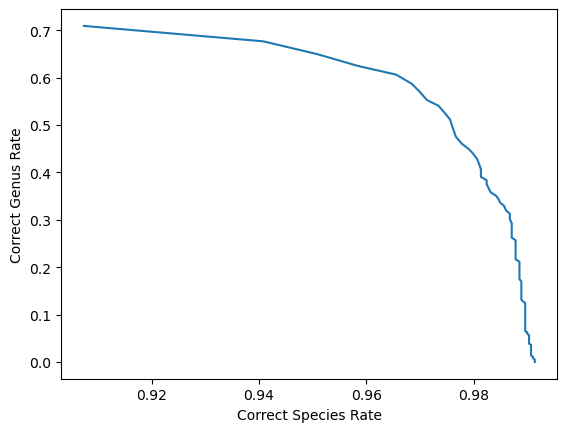

In [53]:
area_correct = auc(correct_species_rate,correct_genus_rate)
print(area_correct)

plt.plot(correct_species_rate,correct_genus_rate)
plt.xlabel("Correct Species Rate")
plt.ylabel("Correct Genus Rate")

In [54]:
for index in range(0,100,1):
    print(index)
    print(correct_genus_rate[index])
    print(correct_species_rate[index])
    print('\n\n')

0
0.0
0.9913854989231874



1
0.004815795810257645
0.9913854989231874



2
0.007946063086925114
0.9910265613783201



3
0.010835540573079701
0.9910265613783201



4
0.01396580784974717
0.990667623833453



5
0.01709607512641464
0.990667623833453



6
0.019022393450517698
0.990667623833453



7
0.020948711774620755
0.990667623833453



8
0.02335660967974958
0.990667623833453



9
0.027450036118468576
0.990667623833453



10
0.031543462557187575
0.990667623833453



11
0.036118468576932336
0.990667623833453



12
0.03852636648206116
0.9903086862885858



13
0.042379003130267275
0.9903086862885858



14
0.04695400915001204
0.9903086862885858



15
0.05249217433180833
0.9903086862885858



16
0.05634481098001445
0.9903086862885858



17
0.059956657837707684
0.9899497487437185



18
0.06260534553334939
0.9899497487437185



19
0.06501324343847821
0.9895908111988514



20
0.06886588008668433
0.9895908111988514



21
0.07271851673489044
0.9895908111988514



22
0.07657115338309656
0.989590811

In [56]:
print(correct_genus_rate[50])
correct_species_rate[50]

0.20635685046954008


0.9885139985642498